In [2]:
import pandas as pd

df = pd.read_csv('./data/form.csv')
df.columns = ['timestamp', 'sex', 'age', 'city','employee_sum', 'yearly', 'yearly_bonus', 'stock_options', 'position', 'experience', 'education', 'insurance']

def ganti_education(s): 
    if 's1' in s.lower() or 's.' in s.lower() or 'sarjana' in s.lower() or 'bachelor' in s.lower() or 'b.' in s.lower() or 'ilmu komputer' in s.lower(): 
        return 'S1'
    elif 's2' in s.lower() or 'master' in s.lower(): 
        return 's2'
    elif 'smk' in s.lower() or 'sma' in s.lower() or 'senior year' in s.lower() or 'man' in s.lower() or 'college courses' in s.lower() or 'smu' in s.lower(): 
        return 'SMA'
    elif 'diploma' in s.lower() or 'd4' in s.lower() or 'd3' in s.lower() or 'd2' in s.lower() or 'd1' in s.lower(): 
        return 'diploma'
    elif 'self taught' == s.lower(): 
        return 'self taught'
    else: 
        return 'KELAINAN'

def ngisi_experience_masa_pake_tahun(s):
    if isinstance(s, float): 
        return s
    
    if s: 
        for a in s.split(): 
            if a.isdigit(): 
                return int(a)
    else: 
        return 0

def jakarta_mah_jakarta_aja(s): 
    if 'jakarta' in s.lower(): 
        return 'jakarta'
    else: 
        return 'not jakarta'

def insurance_to_categorical(ins):
    if isinstance(ins, float): 
        return 'no'
    elif ins.isdigit(): 
        if int(ins)>0: 
            return 'no'
        else: 
            return 'yes'
    elif isinstance(ins, str): 
        return 'yes'


df['education'] = df['education'].apply(ganti_education)
df['experience'] = df['experience'].apply(ngisi_experience_masa_pake_tahun)

df['yearly'] = df['yearly'].str.replace('.','')
df['yearly_bonus'] = df['yearly_bonus'].str.replace('.','')

df['yearly'] = pd.to_numeric(df['yearly'])
df['yearly_bonus'] = pd.to_numeric(df['yearly_bonus'])

df['yearly_bonus'] = df['yearly_bonus'].fillna(0)
df['stock_options'] = df['stock_options'].fillna(0)


df['city'] = df['city'].apply(jakarta_mah_jakarta_aja)
df['insurance'] = df['insurance'].apply(insurance_to_categorical)


df.drop('timestamp', inplace=True, axis=1)
df_ohe = pd.get_dummies(df)


In [7]:
df_ohe = df_ohe.loc[:,~df_ohe.columns.duplicated()]

In [9]:
X = df_ohe.loc[:, df_ohe.columns !='yearly']
y = df_ohe['yearly']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [42]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 500)

params = {  
    "n_estimators": [x for x in range(5,100)],
    "max_depth":[x for x in range(4,100)],
    "learning_rate": st.uniform(0.0005, 1),
    "objective":['reg:tweedie'],
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 100),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=-1, verbose=2, cv=10, random_state=42, n_iter=100)  
gs.fit(X_train, y_train)  
print(f'score: {gs.best_score_}')
print(f'params: {gs.best_params_}')
      

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


score: 0.11349438887508483
params: {'colsample_bytree': 0.7700780475136861, 'gamma': 49.07487792587845, 'learning_rate': 0.7233960966217756, 'max_depth': 65, 'min_child_weight': 1325.1925474799777, 'n_estimators': 83, 'objective': 'reg:tweedie', 'reg_alpha': 382.89843507995596, 'subsample': 0.847370572449075}


In [43]:
best_params = gs.best_params_
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best params: 
colsample_bytree: 0.7700780475136861
gamma: 49.07487792587845
learning_rate: 0.7233960966217756
max_depth: 65
min_child_weight: 1325.1925474799777
n_estimators: 83
objective: 'reg:tweedie'
reg_alpha: 382.89843507995596
subsample: 0.847370572449075


In [45]:
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7700780475136861,
             gamma=49.07487792587845, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.7233960966217756,
             max_delta_step=0, max_depth=65,
             min_child_weight=1325.1925474799777, missing=nan,
             monotone_constraints=None, n_estimators=83, n_jobs=0,
             num_parallel_tree=1, objective='reg:tweedie', random_state=0,
             reg_alpha=382.89843507995596, reg_lambda=1, scale_pos_weight=None,
             subsample=0.847370572449075, tree_method=None,
             validate_parameters=False, verbosity=None)

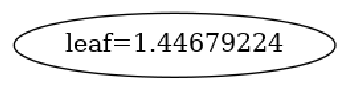

In [49]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_tree(best_model)
plt.show()